Notebook for plotting behavior related to Rachel Wahlberg circular maze task.

In [2]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    assert False, 'plot_dir not yet implemented on Nat laptop'
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Import CircularPosition class
sys.path.extend(['/data3/Rachel/Recording_Rats/'])
from circularPosition import CircularPosition

### Look at Cho 11/17/2024 Session 2

In [18]:
pos_dict = np.load(sorted(basepath.glob("*.position.npy"))[0], allow_pickle=True).item()
pos_dict.keys()

dict_keys(['traces', 't_start', 'sampling_rate', 'traces_rot', 'metadata'])

In [27]:
basepath = Path("/data3/Rachel/Recording_Rats/Cho/2024_11_17_session2")
pos_dict = np.load(sorted(basepath.glob("*.position.npy"))[0], allow_pickle=True).item()
circpos = CircularPosition(traces=pos_dict['traces'], t_start=pos_dict['t_start'], sampling_rate=pos_dict['sampling_rate'],
                           metadata=pos_dict['metadata'])
circpos_rot = CircularPosition(traces=pos_dict['traces_rot'], t_start=pos_dict['t_start'], sampling_rate=pos_dict['sampling_rate'],
                           metadata=pos_dict['metadata'])

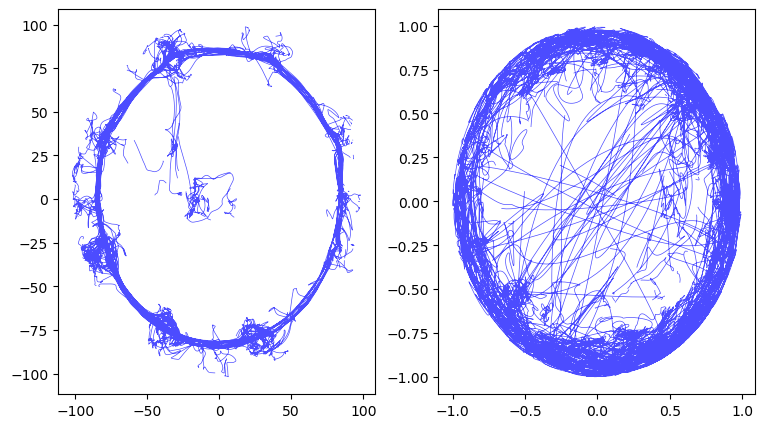

In [37]:
_, ax = plt.subplots(1, 2, figsize=(9, 5))
for a, pos_use, name in zip(ax, [circpos, circpos_rot], ["No rotate", "Rotate"]):
    a.plot(pos_use.traces[0], pos_use.traces[2], linewidth=0.5, color=[0, 0, 1, 0.3])

In [93]:
from neuropy.utils.position_util import linearize_position
linpos = linearize_position(circpos, dimensions=["x", "z"])

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. li

In [100]:
linpos.traces.shape

(1, 398452)

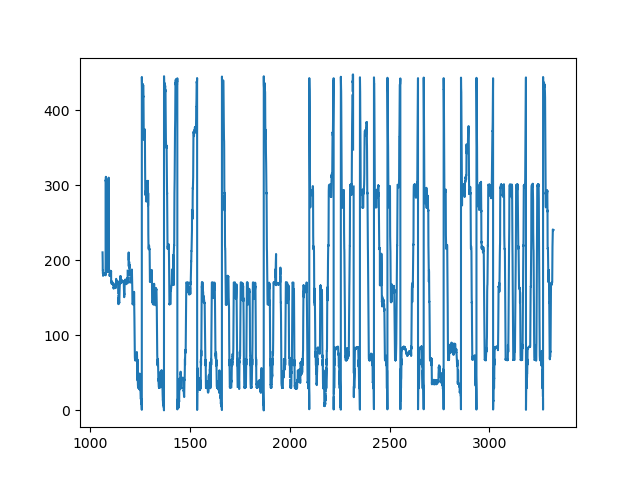

In [101]:
_, ax = plt.subplots()
ax.plot(linpos.time, linpos.traces[0])

#### Now plot dwell time in reward ports for each block

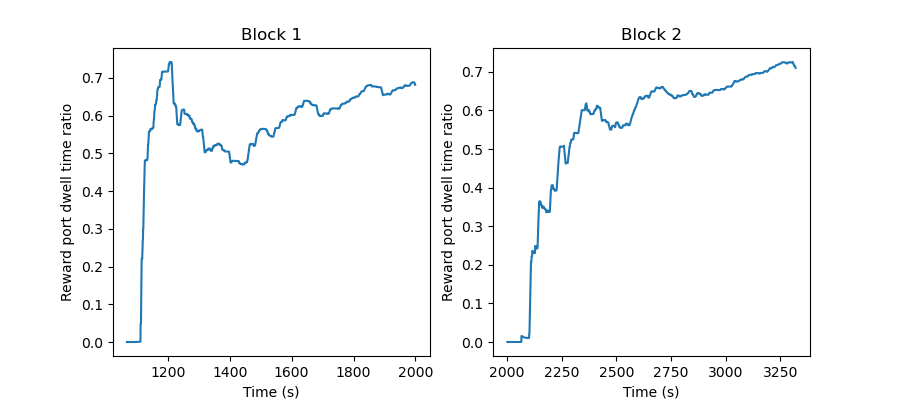

In [130]:
port1 = [145, 175]
port2 = [25, 50]

port3 = [285, 305]
port4 = [65, 90]

approx_switch_time = 2000
t_on_maze = 1000

speed_thresh = 3
pos_thresh = linpos.traces[0, (circpos.speed < speed_thresh) & (circpos.time > t_on_maze)]
t_thresh = circpos.time[(circpos.speed < speed_thresh) & (circpos.time > t_on_maze)]

dwell_time_list = []
time_list = []
for blk, porta, portb in zip([1, 2], [port1, port3], [port2, port4]):
    if blk == 1:
        t_use = t_thresh[t_thresh < approx_switch_time]
        pos_use = pos_thresh[t_thresh < approx_switch_time]
    else:
        t_use = t_thresh[t_thresh > approx_switch_time]
        pos_use = pos_thresh[t_thresh > approx_switch_time]        
    
    dwell_bool = np.zeros_like(t_use).astype(bool)
    dwell_bool[((pos_use > porta[0]) & (pos_use < porta[1])) | ((pos_use > portb[0]) & (pos_use < portb[1]))] = True
    dwell_time_list.append(dwell_bool)
    time_list.append(t_use)
    
_, ax = plt.subplots(1, 2, figsize=(9, 4))
for a, dbool, t_use, blk in zip(ax, dwell_time_list, time_list, [1, 2]):
    dwell_ratio = np.cumsum(dbool) / np.arange(1, 1 + len(dbool))
    a.plot(t_use, dwell_ratio)
    a.set_title(f"Block {blk}")
    a.set_ylabel("Reward port dwell time ratio")
    a.set_xlabel("Time (s)")

### Plot occupancy across whole session

[]

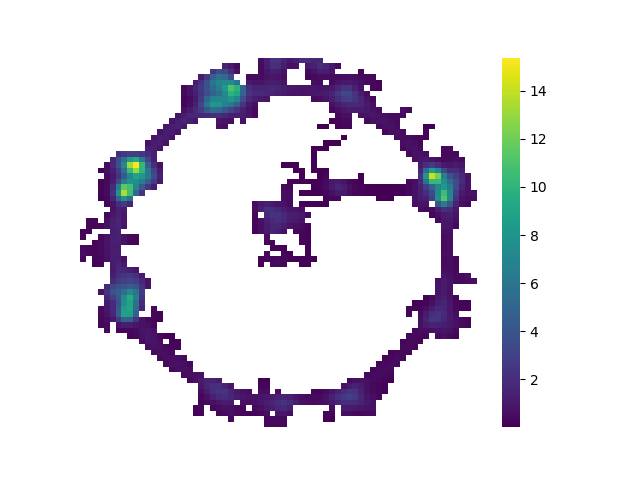

In [131]:
from scipy.ndimage import gaussian_filter
sigma = 3
grid_bin = 3
# smooth_ = lambda f: gaussian_filter1d(f, sigma / grid_bin, axis=-1) 
smooth_ = lambda f: gaussian_filter(f, sigma / grid_bin) 

x = circpos.traces[0]
z = circpos.traces[2]
x_grid = np.arange(np.nanmin(x), np.nanmax(x) + grid_bin, grid_bin)
z_grid = np.arange(np.nanmin(z), np.nanmax(z) + grid_bin, grid_bin)

speed_thresh = 0
x_thresh = x[circpos.speed > speed_thresh]
z_thresh = z[circpos.speed > speed_thresh]

occupancy = np.histogram2d(x_thresh, z_thresh, bins=(x_grid, z_grid))[0]
zero_occ_bool = occupancy == 0
occupancy = occupancy / circpos.sampling_rate + 10e-16
occupancy = smooth_(occupancy)
occupancy[zero_occ_bool] = np.nan

_, ax = plt.subplots()
sns.heatmap(occupancy, cmap='viridis', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
# sns.despine(ax=ax)

### Below shows how occupancy changes after the rule switch

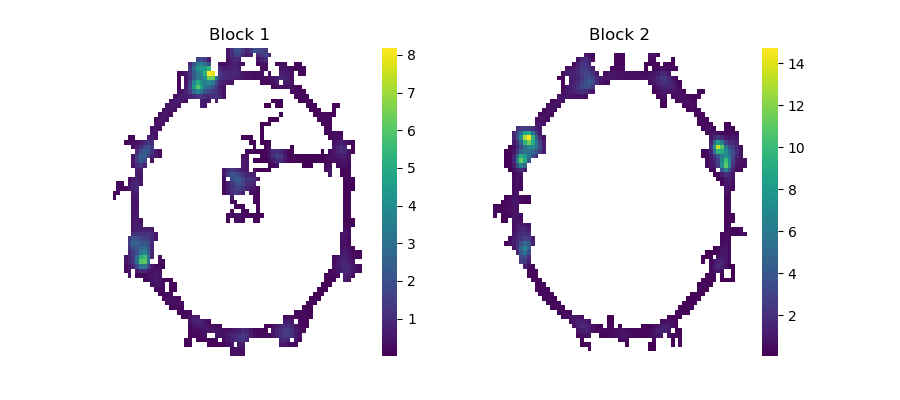

In [105]:
# plot before and after switch
approx_switch_time = 2000

x = circpos.traces[0]
z = circpos.traces[2]
x_grid = np.arange(np.nanmin(x), np.nanmax(x) + grid_bin, grid_bin)
z_grid = np.arange(np.nanmin(z), np.nanmax(z) + grid_bin, grid_bin)

speed_thresh = 0
x_thresh = x[circpos.speed > speed_thresh]
z_thresh = z[circpos.speed > speed_thresh]
t_thresh = circpos.time[circpos.speed > speed_thresh]

_, ax = plt.subplots(1, 2, figsize=(9, 4))

for a, blk, in zip(ax, [1, 2]):
    if blk == 1:
        x_use, z_use = x_thresh[t_thresh <= approx_switch_time], z_thresh[t_thresh <= approx_switch_time]
    elif blk == 2:
        x_use, z_use = x_thresh[t_thresh > approx_switch_time], z_thresh[t_thresh > approx_switch_time]
        
    occupancy = np.histogram2d(x_use, z_use, bins=(x_grid, z_grid))[0]
    zero_occ_bool = occupancy == 0
    occupancy = occupancy / circpos.sampling_rate + 10e-16
    occupancy = smooth_(occupancy)
    occupancy[zero_occ_bool] = np.nan
    
    
    sns.heatmap(occupancy, cmap='viridis', ax=a)
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(f"Block {blk}")

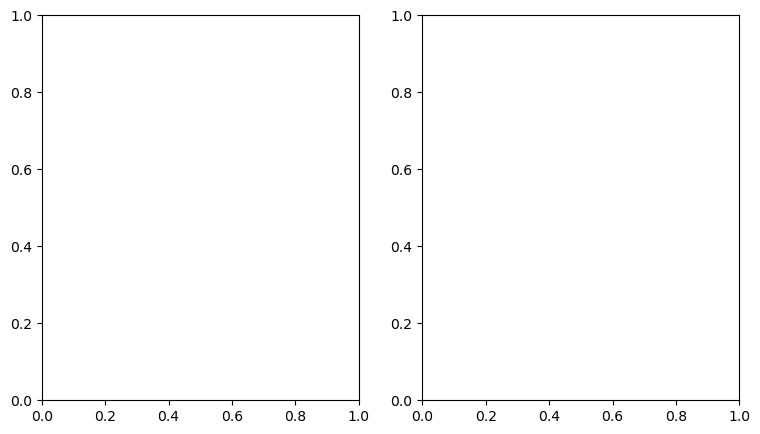

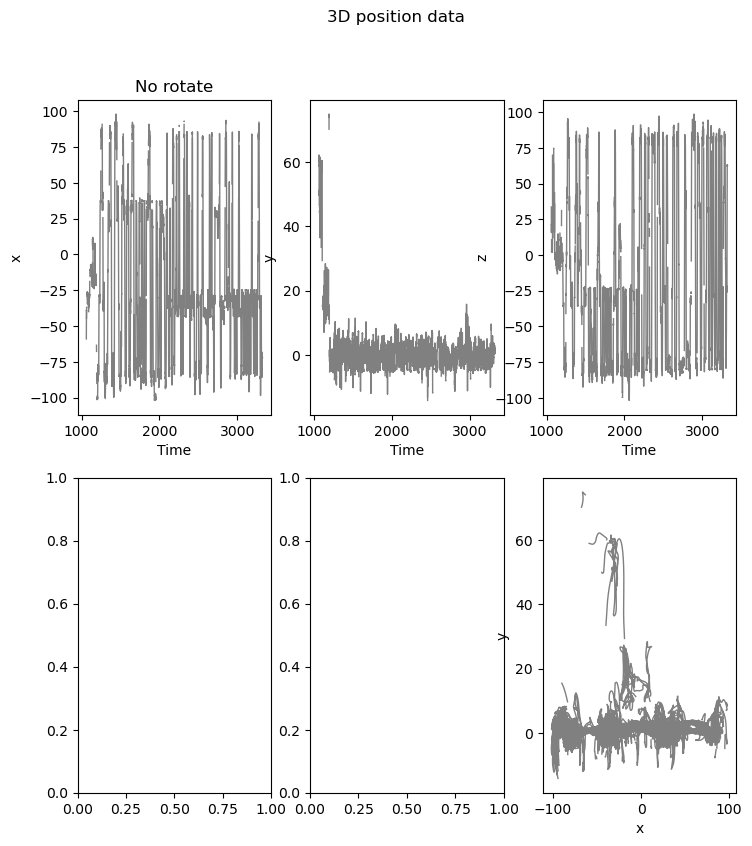

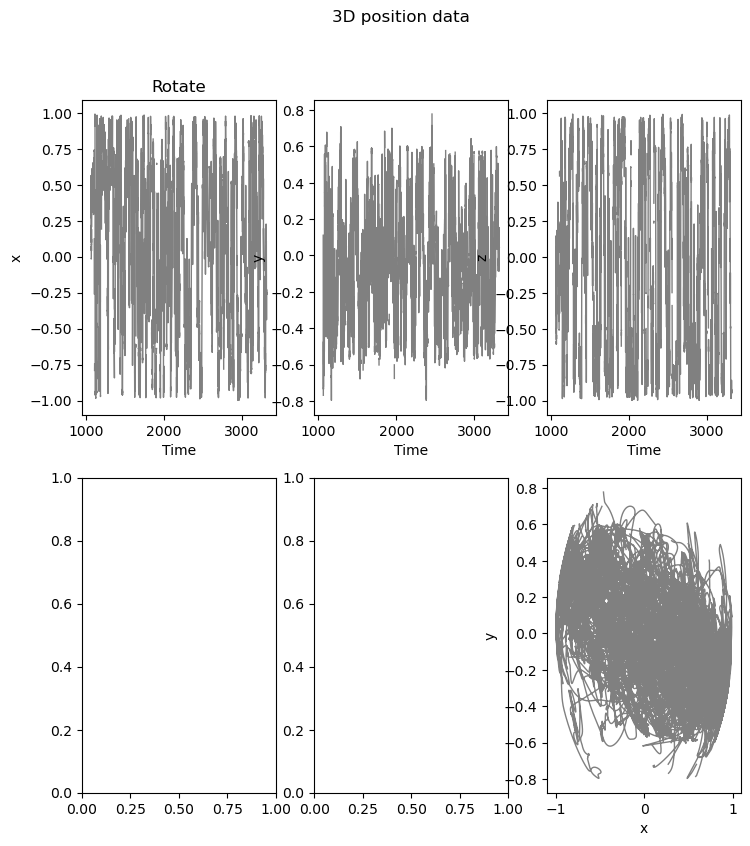

In [32]:
from neuropy.plotting.position import plot_position
_, ax = plt.subplots(1, 2, figsize=(9, 5))
for a, pos_use, name in zip(ax, [circpos, circpos_rot], ["No rotate", "Rotate"]):
    ause = plot_position(pos_use)
    ause.reshape(-1)[0].set_title(name)